# Implementing Early Stopping for Tree-Parzen Estimator Optimization
This notebook provides the code underlying the findings in the paper. The notebook evaluates the efficacy of Bayesian hyperparameter optimization using Tree-Parzen Estimators (TPE), an optimizer that builds a posterior of particular hyperparameter configurations yielding an objective loss value. Using an iterative approach (referred to as 'epochs' for this notebook), the optimizer approaches a hyperparameter configuration minimizes objective loss.  
  
The notebook first measures the marginal effect per epoch of running TPE while using Random Search as a baseline, and then configures / tests a method of early-stopping for TPE, where the algorithm will stop running through epochs once certain thresholds are met. The results are summarized in the accompanying paper. See below table of contents for navigating the notebook.

## Table of Contents  
* #### [Part I: Measuring returns per epoch](#1)
    * [OLS](#1a)
        * [TPE](#1ai)
        * [Random search](#1aii)
        * [Comparison](#1aiii)
    * [Strong Neural Net](#1b)
        * [TPE](#1bi)
        * [Random search](#1bii)
        * [Comparison](#1biii)
    * [Weak Neural Net](#1c)
        * [TPE](#1ci)
        * [Random search](#1cii)
        * [Comparison](#1ciii)
* #### [Part II: Early stopping implementation](#2)
    * [OLS](#2a)
    * [Strong Neural Net](#2b)
    * [Weak Neural Net](#2c)

In [46]:
import numpy as np
import pandas as pd
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from hyperopt import hp, tpe, rand, Trials, fmin
from hyperopt.pyll.stochastic import sample

import torch
import torch.nn as nn
import torchvision

In [82]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

# Part I: Measuring returns per epoch <a class="anchor" id="1"></a>

## a. OLS <a class="anchor" id="1a"></a>

In [21]:
# Generate random training data for an OLS problem with random parameters
ols_x = np.random.randint(-10, 10, size=500)
ols_y = np.random.randint(0,50)*ols_x + np.random.randint(0,50)

#### TPE <a class="anchor" id="1ai"></a>

In [22]:
# set up model (tracking point of minimum loss)
def tpe_ols(params):
    beta0 = params['beta0']
    beta1 = params['beta1']
    
    loss = sum((ols_y - beta0 - beta1*ols_x)**2)
    
    global tpe_min_losses
    global tpe_min_loss
    
    if tpe_min_loss == None or loss < tpe_min_loss:
        tpe_min_loss = loss
    tpe_min_losses.append(tpe_min_loss)
    
    return loss

In [79]:
# Find optimal parameters using Hyperopt library
# define parameter space
space = {
    'beta0': hp.uniform('beta0', -100, 100),
    'beta1': hp.uniform('beta1', -100, 100)
}

tpe_algo = tpe.suggest # select TPE algorithm
tpe_trials = Trials() # declare variable to access intermediate epoch info (for analysis)

# declare global variables to track changes in loss over epochs
tpe_min_losses = []
tpe_min_loss = None

# run optimizer
tpe_best = fmin(fn=tpe_ols, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))

tpe_best

100%|█████████████████████████████████████████████| 2000/2000 [00:29<00:00, 66.98trial/s, best loss: 521.1712035214351]


{'beta0': 10.76592837253753, 'beta1': 16.14118251639113}

#### Random search <a class="anchor" id="1aii"></a>

In [24]:
# set up model
def ols(params):
    beta0 = params['beta0']
    beta1 = params['beta1']
    
    return sum((ols_y - beta0 - beta1*ols_x)**2)

In [33]:
params = np.zeros((100,100))
params.fill(np.iinfo(int).max-1)
rand_min_losses = []
rand_min_loss = None

time0 = time.time()
for _ in range(2000): # 2000 epochs
    b0 = np.random.randint(0,50)
    b1 = np.random.randint(0,50)
    
    loss = ols({'beta0': b0, 'beta1': b1})
    params[b0,b1] = loss
    
    if rand_min_loss == None or loss < rand_min_loss:
        rand_min_loss = loss
    rand_min_losses.append(rand_min_loss)

print(time.time() - time0)

np.unravel_index(params.argmin(), params.shape)

0.24260807037353516


(11, 16)

#### Comparison of Random search and TPE <a class="anchor" id="1aiii"></a>

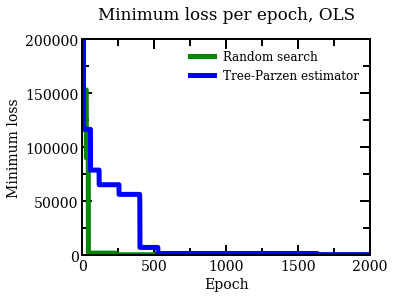

In [240]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(rand_min_losses, label="Random search", linewidth=5, color='#008800')
plt.plot(tpe_min_losses, label="Tree-Parzen estimator", linewidth=5, color='#0000FF')
plt.title("Minimum loss per epoch, OLS", pad=20)
plt.xlabel("Epoch")
plt.ylabel("Minimum loss")
plt.xlim(0,2000)
plt.ylim(0,200_000)

ax.legend(bbox_to_anchor=(1, 1), loc=1, frameon=False, fontsize=12)

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(500))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(250))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(50_000))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(25_000))

plt.show()

In [48]:
print(f"TPE: min loss of {tpe_min_loss :.2f} obtained at epoch {tpe_min_losses.index(tpe_min_loss)}")
print(f"Random: min loss of {rand_min_loss} obtained at epoch {rand_min_losses.index(rand_min_loss)}")

TPE: min loss of 559.59 obtained at epoch 1344
Random: min loss of 0 obtained at epoch 1444


In [64]:
# percent decrease in loss per epoch
percent_loss_rand = [(rand_min_losses[i] - rand_min_losses[i-1]) / rand_min_losses[i-1] for i in range(1,len(rand_min_losses))]
percent_loss_tpe = [(tpe_min_losses[i] - tpe_min_losses[i-1]) / tpe_min_losses[i-1] for i in range(1,len(tpe_min_losses))]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in int_scalars
  


In [68]:
acceptable_loss_rand = [(loss - rand_min_loss) / rand_min_loss for loss in rand_min_losses]
acceptable_loss_tpe = [(loss - tpe_min_loss) / tpe_min_loss for loss in tpe_min_losses]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in int_scalars
  """Entry point for launching an IPython kernel.
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in int_scalars
  """Entry point for launching an IPython kernel.


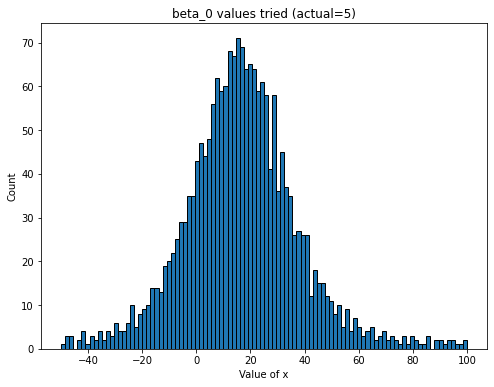

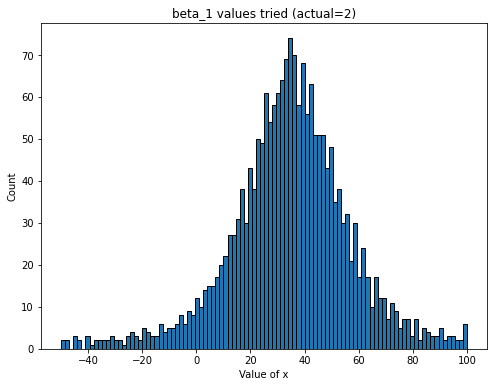

In [ ]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_trials.idxs_vals[1]['beta0'], bins = 100, edgecolor = 'k', range=(-50,100));
plt.title('beta_0 values tried (actual=5)'); plt.xlabel('Value of x'); plt.ylabel('Count');

plt.figure(figsize = (8, 6))
plt.hist(tpe_trials.idxs_vals[1]['beta1'], bins = 100, edgecolor = 'k', range=(-50,100));
plt.title('beta_1 values tried (actual=2)'); plt.xlabel('Value of x'); plt.ylabel('Count');

## b. Strong Neural Net (with MNIST) <a class="anchor" id="1b"></a>

In [ ]:
# Set up model
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

transform = torchvision.transforms.ToTensor()
mnist_train = torchvision.datasets.MNIST(root='.', train=True, transform=transform, download=True)

mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, (int(0.9*len(mnist_train)), int(0.1*len(mnist_train))))

# model with smaller convolutional layers
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.flatten = Flatten()
        
        self.fc1 = nn.Linear(in_features = 800, out_features = 128)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features = 128, out_features = 10)


    def forward(self, x):     
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
                
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu3(x)
        
        x = self.fc2(x)

        return x
    
# model with larger convolutional layers
class LargerModel(nn.Module):
    def __init__(self):
        super(LargerModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.flatten = Flatten()
        
        self.fc1 = nn.Linear(in_features = 1600, out_features = 256)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features = 256, out_features = 10)


    def forward(self, x):     
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
                
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.relu3(x)
        
        x = self.fc2(x)

        return x

In [ ]:
# train model using one of the architectures defined above
def run_model(batch_size=32, alpha=0.001, beta=0.99, model_to_use='simple', num_epochs=5):
    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size)
    
    if model_to_use == 'simple':
        model = SimpleModel()
    else:
        model = LargerModel()
        
    optimizer = torch.optim.SGD(model.parameters(), lr=alpha, momentum=beta)
    loss = torch.nn.CrossEntropyLoss()
    
    val_errors   = []
    
    val_error = 0
    for X, y in val_loader:
        val_error += sum([torch.argmax(preds) for preds in model(X)] != y.numpy())

    val_error /= len(mnist_val)
    val_errors.append(val_error)

    def train():
        for X, y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            
            tloss = loss(output, y)
            tloss.backward()    
            optimizer.step()
            
    for epoch in range(num_epochs):
        train()
        
        val_error = 0
        for X, y in val_loader:
            val_error += sum([torch.argmax(preds) for preds in model(X)] != y.numpy())

        val_error /= len(mnist_val)
        val_errors.append(val_error)
        
    return val_errors

In [ ]:
final_validation_errs = []
validation_errs = []

# compute validation error of a run
# parameterized on batch size, learning rate, momentum coefficient and model network size
def objective_err(params):
    params['batch_size'] = int(2**params['batch_size'])
    
    val_errs = run_model(batch_size=params['batch_size'], 
                         alpha=params['alpha'],
                         beta=params['beta'],
                         model_to_use=params['model_to_use'])

    global validation_errs
    global final_validation_errs

    validation_errs.append(val_errs)
    final_validation_errs.append(val_errs[-1])    

    return val_errs[-1]
    
space = {
    'batch_size': hp.quniform('batch_size', 4, 7, 1),
    'alpha': hp.uniform('alpha', 0.00001, 0.1),
    'beta': hp.uniform('beta', 0, 1),
    'model_to_use': hp.choice('model_to_use', ["simple", "larger"])
}

#### TPE <a class="anchor" id="1bi"></a>

In [ ]:
tpe_algo = tpe.suggest
tpe_trials = Trials()

tpe_best = fmin(fn=objective_err, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=50, rstate= np.random.RandomState(50))

print(f"Optimal parameters are: {tpe_best}")



  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]

  1%|          | 1/100 [00:52<1:26:18, 52.31s/it, best loss: 0.04816666666666667]

  2%|▏         | 2/100 [01:44<1:25:27, 52.32s/it, best loss: 0.04816666666666667]

  3%|▎         | 3/100 [02:07<1:10:31, 43.63s/it, best loss: 0.04616666666666667]

  4%|▍         | 4/100 [02:33<1:01:08, 38.21s/it, best loss: 0.04616666666666667]

  5%|▌         | 5/100 [03:26<1:07:21, 42.54s/it, best loss: 0.03283333333333333]

  6%|▌         | 6/100 [03:50<57:51, 36.93s/it, best loss: 0.03283333333333333]  

  7%|▋         | 7/100 [04:42<1:04:22, 41.53s/it, best loss: 0.03283333333333333]

  8%|▊         | 8/100 [05:35<1:08:54, 44.94s/it, best loss: 0.03283333333333333]

  9%|▉         | 9/100 [06:27<1:11:37, 47.23s/it, best loss: 0.03283333333333333]

 10%|█         | 10/100 [07:21<1:13:40, 49.11s/it, best loss: 0.03283333333333333]

 11%|█         | 11/100 [08:14<1:14:33, 50.26s/it, best loss: 0.03283333333333333]

 12%|█▏        | 12/100 [08:

In [ ]:
tpe_validation_errs = validation_errs.copy()
tpe_final_validation_errs = final_validation_errs.copy()

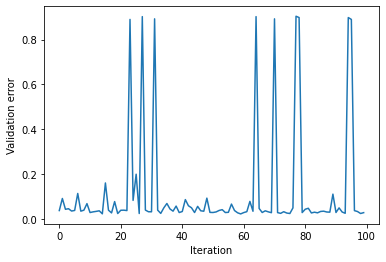

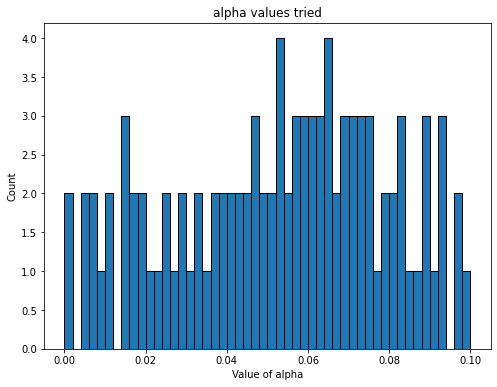

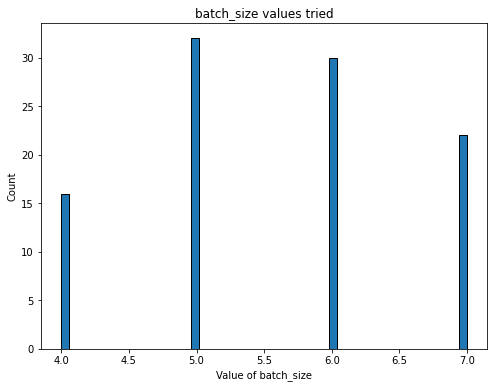

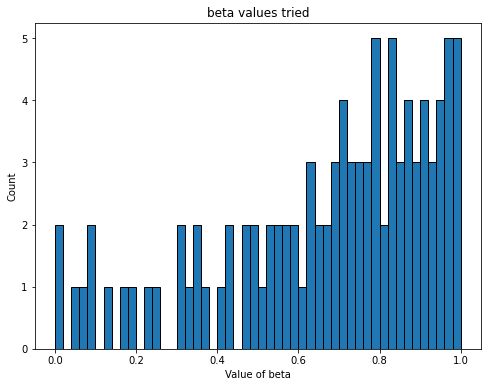

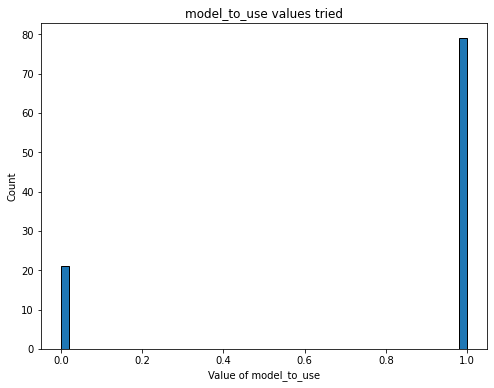

In [ ]:
plt.plot(final_validation_errs)
plt.xlabel("Iteration")
plt.ylabel("Validation error")

ranges = {
    'batch_size': (4, 7),
    'alpha': (0.00001, 0.1),
    'beta': (0,1),
    'model_to_use': (0,1)

}
for k,v in tpe_trials_err.idxs_vals[1].items():
    plt.figure(figsize = (8, 6))
    plt.hist(v, bins = 50, edgecolor = 'k', range=ranges[k])
    plt.title(f'{k} values tried'); plt.xlabel(f'Value of {k}'); plt.ylabel('Count');

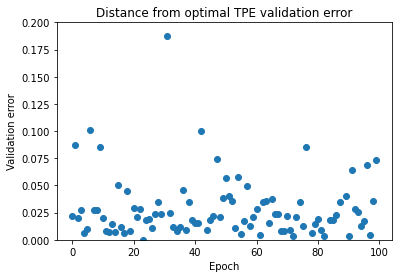

In [ ]:
best_tpe = tpe_trials.best_trial['result']['loss']

plt.scatter(range(0,100), [i['loss'] - best_tpe for i in tpe_trials.results])
plt.ylim(0,0.2)
plt.title("Distance from optimal TPE validation error")
plt.xlabel("Epoch")
plt.ylabel("Validation error")
plt.show()

#### Random search <a class="anchor" id="1bii"></a>

In [ ]:
rand_algo = rand.suggest
rand_trials = Trials()

rand_best = fmin(fn=objective_err, space=space, algo=rand_algo, trials=rand_trials, 
                max_evals=100, rstate= np.random.RandomState(50))

print(f"Optimal parameters are: {rand_best}")



  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

  2%|▏         | 1/50 [00:49<40:40, 49.81s/it, best loss: 0.039]

  4%|▍         | 2/50 [01:39<39:52, 49.85s/it, best loss: 0.039]

  6%|▌         | 3/50 [02:02<32:43, 41.77s/it, best loss: 0.039]

  8%|▊         | 4/50 [02:26<28:00, 36.53s/it, best loss: 0.039]

 10%|█         | 5/50 [03:17<30:26, 40.58s/it, best loss: 0.039]

 12%|█▏        | 6/50 [03:39<25:44, 35.11s/it, best loss: 0.039]

 14%|█▍        | 7/50 [04:29<28:19, 39.53s/it, best loss: 0.039]

 16%|█▌        | 8/50 [05:19<29:55, 42.76s/it, best loss: 0.039]

 18%|█▊        | 9/50 [06:09<30:41, 44.91s/it, best loss: 0.03716666666666667]

 20%|██        | 10/50 [07:00<31:11, 46.79s/it, best loss: 0.03716666666666667]

 22%|██▏       | 11/50 [07:50<30:59, 47.68s/it, best loss: 0.03716666666666667]

 24%|██▍       | 12/50 [08:13<25:31, 40.30s/it, best loss: 0.033666666666666664]

 26%|██▌       | 13/50 [08:37<21:45, 35.29s/it, best loss: 0.0305]              

 28%|██▊  

In [ ]:
rand_validation_errs = validation_errs.copy()
rand_final_validation_errs = final_validation_errs.copy()

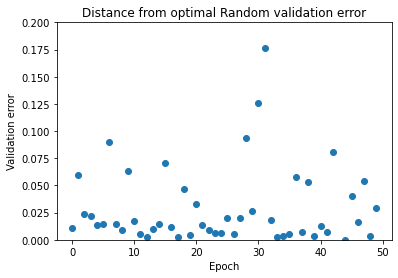

In [ ]:
best_tpe = rand_trials.best_trial['result']['loss']

plt.scatter(range(0,50), [i['loss'] - best_tpe for i in rand_trials.results])
plt.ylim(0,0.2)
plt.title("Distance from optimal Random validation error")
plt.xlabel("Epoch")
plt.ylabel("Validation error")
plt.show()

#### Comparison of Random search and TPE <a class="anchor" id="1biii"></a>

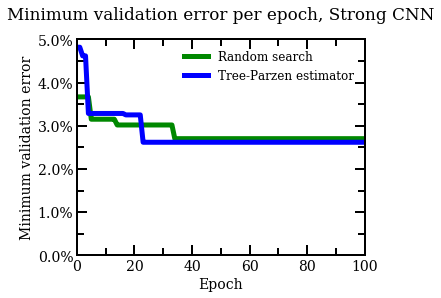

In [241]:
# Hard-saving data from one (representative) run
mnist_tpe_best_validation_errs = [0.04816666666666667, 0.04816666666666667, 0.04616666666666667, 0.04616666666666667, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668]
mnist_rand_best_validation_errs = [0.03666666666666667,0.03666666666666667,0.03666666666666667,0.03666666666666667,0.03666666666666667,0.0315,0.0315,0.0315,0.0315,0.0315,0.0315,0.0315,0.0315,0.0315,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.030166666666666668,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027,0.027]

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(mnist_rand_best_validation_errs, linewidth=5, label="Random search", color='#008800')
plt.plot(mnist_tpe_best_validation_errs, linewidth=5, label="Tree-Parzen estimator", color='#0000FF')
plt.title("Minimum validation error per epoch, Strong CNN", pad=20)
plt.ylabel("Minimum validation error")
plt.xlabel("Epoch")
plt.xlim(0,100)
plt.ylim(0,0.05)

ax.legend(bbox_to_anchor=(1, 1), loc=1, frameon=False, fontsize=12)

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: str(round(100*float(x), 1)) + "%"))

plt.show()

In [94]:
mnist_rand_min_loss = min(mnist_rand_best_validation_errs)
mnist_tpe_min_loss = min(mnist_tpe_best_validation_errs)

In [95]:
acceptable_loss_mnist_rand = [(loss - mnist_rand_min_loss) / mnist_rand_min_loss for loss in mnist_rand_best_validation_errs]
acceptable_loss_mnist_tpe = [(loss - mnist_tpe_min_loss) / mnist_tpe_min_loss for loss in mnist_tpe_best_validation_errs]

## c. Weak Neural Net (with CIFAR-10) <a class="anchor" id="1c"></a>

In [ ]:
# Set up model
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

transform = torchvision.transforms.ToTensor()
cifar_train = torchvision.datasets.CIFAR10(root='.', train=True, transform=transform, download=True)

cifar_train, cifar_val = torch.utils.data.random_split(cifar_train, (int(0.9*len(cifar_train)), int(0.1*len(cifar_train))))

class SimpleCIFARModel(nn.Module):
    def __init__(self):
        super(SimpleCIFARModel, self).__init__()

        self.linears = nn.Sequential(
            nn.Linear(3*32*32, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, 128),
            nn.PReLU(),
            nn.Linear(128, 64),
            nn.PReLU(),
            nn.Linear(64, 10)
        )


    def forward(self, x):     
        x = x.view(x.size(0), -1)
        x = self.linears(x)

        return x

Files already downloaded and verified


In [ ]:
def run_cifar_model(batch_size=32, alpha=0.001, beta=0.99, num_epochs=5):
    train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(cifar_val, batch_size=batch_size)
    
    model = SimpleCIFARModel()
        
    optimizer = torch.optim.SGD(model.parameters(), lr=alpha, momentum=beta)
    loss = torch.nn.CrossEntropyLoss()
    
    val_errors   = []
    
    val_error = 0
    for X, y in val_loader:
        val_error += sum([torch.argmax(preds) for preds in model(X)] != y.numpy())

    val_error /= len(mnist_val)
    val_errors.append(val_error)
    # print(f"val error in start: {val_error}")

    def train():
        for X, y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            
            tloss = loss(output, y)
            tloss.backward()    
            optimizer.step()
            
    for epoch in range(num_epochs):
        train()
        
        val_error = 0
        for X, y in val_loader:
            val_error += sum([torch.argmax(preds) for preds in model(X)] != y.numpy())

        val_error /= len(mnist_val)
        val_errors.append(val_error)
        
    return val_errors

In [ ]:
cifar_final_validation_errs = []
cifar_validation_errs = []

def cifar_objective_err(params):
    params['batch_size'] = int(2**params['batch_size'])
    
    val_errs = run_cifar_model(batch_size=params['batch_size'], 
                         alpha=params['alpha'],
                         beta=params['beta'])

    global cifar_validation_errs
    global cifar_final_validation_errs

    cifar_validation_errs.append(val_errs)
    cifar_final_validation_errs.append(val_errs[-1])    

    return val_errs[-1]
    
cifar_space = {
    'batch_size': hp.quniform('batch_size', 4, 7, 1),
    'alpha': hp.uniform('alpha', 0.00001, 0.1),
    'beta': hp.uniform('beta', 0, 1)
}

#### TPE <a class="anchor" id="1ci"></a>

In [ ]:
cifar_tpe_algo = tpe.suggest
cifar_tpe_trials = Trials()

cifar_tpe_best = fmin(fn=cifar_objective_err, space=cifar_space, algo=cifar_tpe_algo, trials=cifar_tpe_trials, 
                max_evals=100, rstate= np.random.RandomState(50))

print(f"Optimal parameters are: {cifar_tpe_best}")

100%|██████████| 100/100 [23:44<00:00, 14.24s/it, best loss: 0.5483333333333333]
Optimal parameters are: {'alpha': 0.053621102064726076, 'batch_size': 4.0, 'beta': 0.4044283759625307}


In [ ]:
cifar_tpe_validation_errs = validation_errs.copy()
cifar_tpe_final_validation_errs = final_validation_errs.copy()

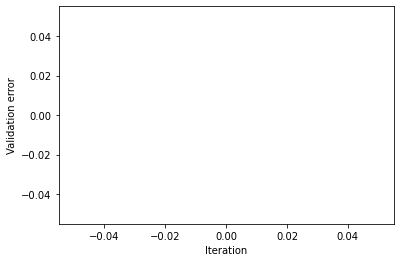

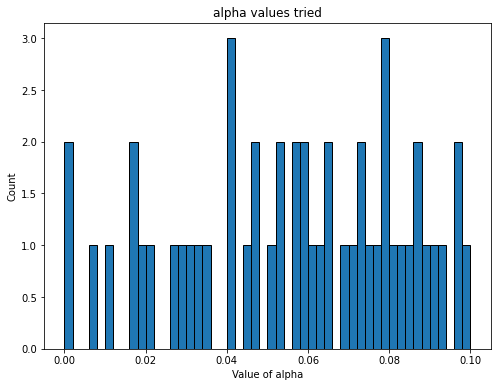

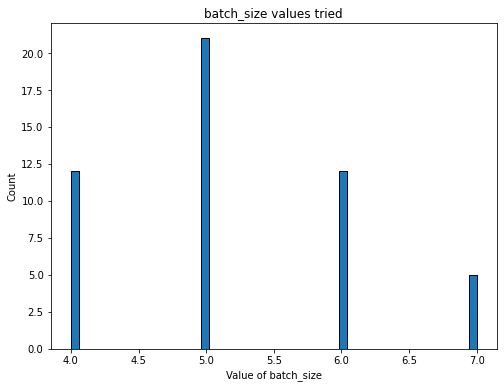

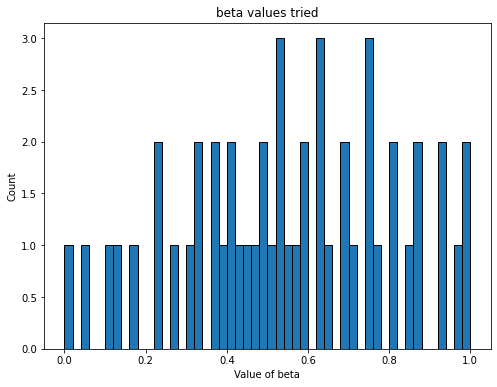

In [ ]:
plt.plot(cifar_tpe_final_validation_errs)
plt.xlabel("Iteration")
plt.ylabel("Validation error")

ranges = {
    'batch_size': (4, 7),
    'alpha': (0.00001, 0.1),
    'beta': (0,1)

}
for k,v in cifar_tpe_trials.idxs_vals[1].items():
    plt.figure(figsize = (8, 6))
    plt.hist(v, bins = 50, edgecolor = 'k', range=ranges[k])
    plt.title(f'{k} values tried'); plt.xlabel(f'Value of {k}'); plt.ylabel('Count');

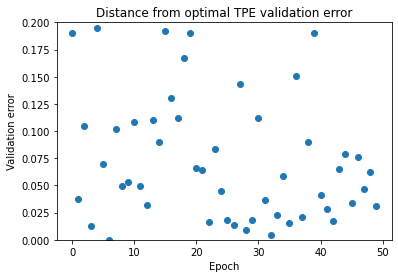

In [ ]:
best_tpe = cifar_tpe_trials.best_trial['result']['loss']

plt.scatter(range(0,50), [i['loss'] - best_tpe for i in cifar_tpe_trials.results])
plt.ylim(0,0.2)
plt.title("Distance from optimal TPE validation error")
plt.xlabel("Epoch")
plt.ylabel("Validation error")
plt.show()

#### Random search <a class="anchor" id="1cii"></a>

In [ ]:
cifar_rand_algo = rand.suggest
cifar_rand_trials = Trials()

cifar_rand_best = fmin(fn=cifar_objective_err, space=cifar_space, algo=cifar_rand_algo, trials=cifar_rand_trials, 
                max_evals=50, rstate= np.random.RandomState(50))

print(f"Optimal parameters are: {cifar_rand_best}")

100%|██████████| 50/50 [14:16<00:00, 17.12s/it, best loss: 0.5646666666666667]
Optimal parameters are: {'alpha': 0.053942918857283736, 'batch_size': 5.0, 'beta': 0.6627955953714144}


In [ ]:
cifar_rand_validation_errs = validation_errs.copy()
cifar_rand_final_validation_errs = final_validation_errs.copy()

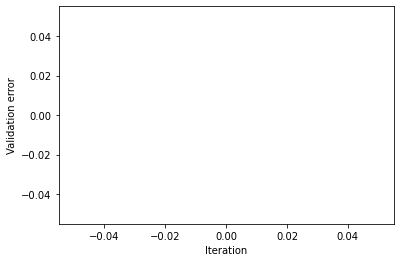

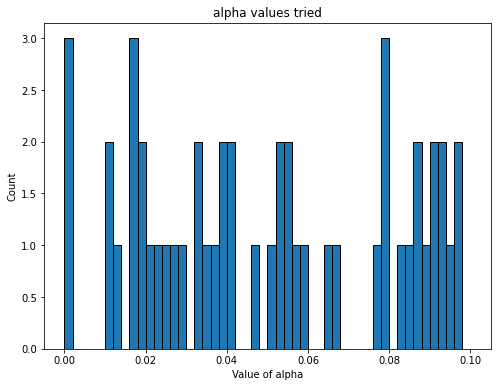

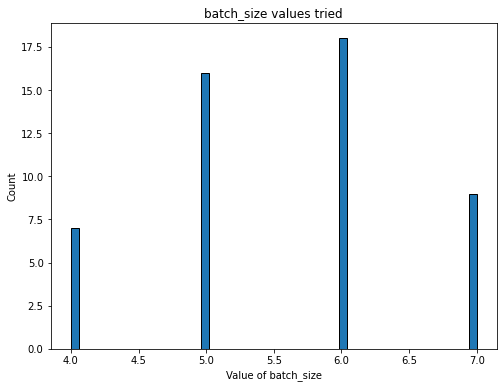

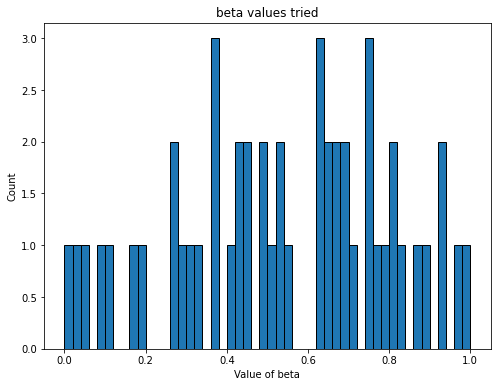

In [ ]:
plt.plot(cifar_rand_final_validation_errs)
plt.xlabel("Iteration")
plt.ylabel("Validation error")

ranges = {
    'batch_size': (4, 7),
    'alpha': (0.00001, 0.1),
    'beta': (0,1)

}
for k,v in cifar_rand_trials.idxs_vals[1].items():
    plt.figure(figsize = (8, 6))
    plt.hist(v, bins = 50, edgecolor = 'k', range=ranges[k])
    plt.title(f'{k} values tried'); plt.xlabel(f'Value of {k}'); plt.ylabel('Count');

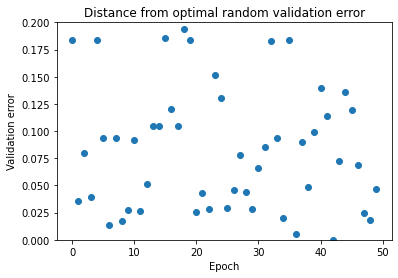

In [ ]:
best_tpe = cifar_rand_trials.best_trial['result']['loss']

plt.scatter(range(0,50), [i['loss'] - best_tpe for i in cifar_rand_trials.results])
plt.ylim(0,0.2)
plt.title("Distance from optimal random validation error")
plt.xlabel("Epoch")
plt.ylabel("Validation error")
plt.show()

#### Comparison of Random search and TPE <a class="anchor" id="1ciii"></a>

In [114]:
# Hard-saving data from one (representative) run
cifar_tpe_validation_errs = [0.7513333333333333,0.5838333333333333,0.64,0.5656666666666667,0.7416666666666667,0.6336666666666667,0.5881666666666666,0.6496666666666666,0.5775,0.5788333333333333,0.6746666666666666,0.6026666666666667,0.6091666666666666,0.6601666666666667,0.6271666666666667,0.7556666666666667,0.6836666666666666,0.6565,0.7556666666666667,0.7513333333333333,0.5961666666666666,0.5761666666666667,0.5665,0.75,0.6453333333333333,0.572,0.6076666666666667,0.6061666666666666,0.7513333333333333,0.5555,0.6346666666666667,0.6388333333333334,0.7203333333333334,0.6766666666666666,0.59,0.7513333333333333,0.5828333333333333,0.6433333333333333,0.548,0.6948333333333333,0.687,0.6915,0.552,0.6241666666666666,0.6951666666666667,0.7106666666666667,0.5605,0.627,0.625,0.5875,0.6301666666666667,0.6448333333333334,0.6043333333333333,0.5691666666666667,0.7253333333333334,0.5823333333333334,0.6791666666666667,0.677,0.6166666666666667,0.5968333333333333,0.5946666666666667,0.6435,0.6063333333333333,0.618,0.5958333333333333,0.5795,0.6606666666666666,0.7115,0.5776666666666667,0.6335,0.6216666666666667,0.6485,0.67,0.645,0.6715,0.7355,0.6818333333333333,0.5966666666666667,0.5828333333333333,0.6423333333333333,0.6168333333333333,0.7513333333333333,0.6181666666666666,0.7473333333333333,0.616,0.7108333333333333,0.6123333333333333,0.66,0.6128333333333333,0.5625,0.595,0.6968333333333333,0.655,0.67,0.6966666666666667,0.5951666666666666,0.6958333333333333,0.6801666666666667,0.6945,0.584]
cifar_tpe_best_validation_errs = [min(cifar_tpe_validation_errs[:(i+1)]) for i in range(len(cifar_tpe_validation_errs))]

In [115]:
cifar_rand_validation_errs = [0.7451666666666666,0.6166666666666667,0.6105,0.7451666666666666,0.592,0.5928333333333333,0.5946666666666667,0.7528333333333334,0.6708333333333333,0.6048333333333333,0.7138333333333333,0.5818333333333333,0.6235,0.6676666666666666,0.6103333333333333,0.5801666666666667,0.6226666666666667,0.6551666666666667,0.7451666666666666,0.686,0.6743333333333333,0.7451666666666666,0.7451666666666666,0.5671666666666667,0.569,0.5961666666666666,0.604,0.567,0.6453333333333333,0.5893333333333334,0.6373333333333333,0.559,0.6353333333333333,0.5611666666666667,0.5948333333333333,0.5721666666666667,0.572,0.5753333333333334,0.6703333333333333,0.5805,0.618,0.566,0.668,0.6536666666666666,0.5818333333333333,0.61,0.6138333333333333,0.69,0.5975,0.5808333333333333,0.6023333333333334,0.6508333333333334,0.7193333333333334,0.6068333333333333,0.5828333333333333,0.6881666666666667,0.5568333333333333,0.6078333333333333,0.606,0.6861666666666667,0.5773333333333334,0.5651666666666667,0.5868333333333333,0.5815,0.556,0.5731666666666667,0.7451666666666666,0.5483333333333333,0.6078333333333333,0.575,0.569,0.5781666666666667,0.5768333333333333,0.6153333333333333,0.5576666666666666,0.6106666666666667,0.6298333333333334,0.5543333333333333,0.5876666666666667,0.7156666666666667,0.5978333333333333,0.5611666666666667,0.6043333333333333,0.5836666666666667,0.597,0.5758333333333333,0.5648333333333333,0.6083333333333333,0.7451666666666666,0.59,0.6061666666666666,0.5983333333333334,0.6161666666666666,0.644,0.7143333333333334,0.5566666666666666,0.6026666666666667,0.563,0.5661666666666667,0.6171666666666666,0.5665,0.5766666666666667,0.6006666666666667]
cifar_rand_best_validation_errs = [min(cifar_rand_validation_errs[:(i+1)]) for i in range(len(cifar_rand_validation_errs))]

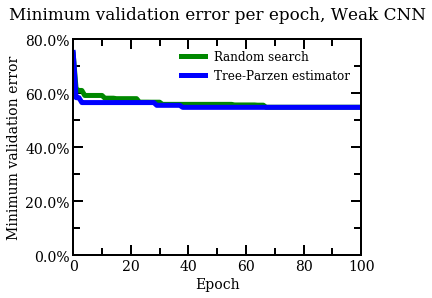

In [242]:
# Hard-saving data from one (representative) run
cifar_rand_best_validation_errs = [0.7451666666666666,0.6166666666666667,0.6105,0.6105,0.592,0.592,0.592,0.592,0.592,0.592,0.592,0.5818333333333333,0.5818333333333333,0.5818333333333333,0.5818333333333333,0.5801666666666667,0.5801666666666667,0.5801666666666667,0.5801666666666667,0.5801666666666667,0.5801666666666667,0.5801666666666667,0.5801666666666667,0.5671666666666667,0.5671666666666667,0.5671666666666667,0.5671666666666667,0.567,0.567,0.567,0.567,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.559,0.5568333333333333,0.5568333333333333,0.5568333333333333,0.5568333333333333,0.5568333333333333,0.5568333333333333,0.5568333333333333,0.5568333333333333,0.556,0.556,0.556,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333,0.5483333333333333]
cifar_tpe_best_validation_errs = [0.7513333333333333,0.5838333333333333,0.5838333333333333,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5656666666666667,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.5555,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548,0.548]

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(cifar_rand_best_validation_errs, linewidth=5, label="Random search", color='#008800')
plt.plot(cifar_tpe_best_validation_errs, linewidth=5, label="Tree-Parzen estimator", color='#0000FF')
plt.title("Minimum validation error per epoch, Weak CNN", pad=20)
plt.ylabel("Minimum validation error")
plt.xlabel("Epoch")
plt.xlim(0,100)
plt.ylim(0,0.8)

ax.legend(bbox_to_anchor=(1, 1), loc=1, frameon=False, fontsize=12)

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: str(round(100*float(x), 1)) + "%"))

plt.show()

In [118]:
cifar_rand_min_loss = min(cifar_rand_best_validation_errs)
cifar_tpe_min_loss = min(cifar_tpe_best_validation_errs)

In [119]:
acceptable_loss_cifar_rand = [(loss - cifar_rand_min_loss) / cifar_rand_min_loss for loss in cifar_rand_best_validation_errs]
acceptable_loss_cifar_tpe = [(loss - cifar_tpe_min_loss) / cifar_tpe_min_loss for loss in cifar_tpe_best_validation_errs]

# Part II: Early stopping implementation <a class="anchor" id="2"></a>

## a. OLS <a class="anchor" id="2a"></a>

In [139]:
# Generate random training data for an OLS problem with random parameters
ols_x = np.random.randint(-10, 10, size=500)
ols_y = np.random.randint(0,50)*ols_x + np.random.randint(0,50)

def early_stop_ols(params):
    beta0 = params['beta0']
    beta1 = params['beta1']

    global stopped
    global losses

    if stopped:
        return losses[-1]
    else:
        global max_epochs
        global min_loss
        global min_loss_idx
        
        loss = sum((ols_y - beta0 - beta1*ols_x)**2)

        if loss < min_loss or len(losses) == 0:
            min_loss = loss
            min_loss_idx = len(losses)+1

        losses.append(loss)

        if len(losses) > max_epochs // 5 and min_loss_idx < len(losses) - max_epochs//10:
            # we're past 20% mark, and new min hasn't been found in the last 10% of epochs
            stopped = True
            print(f"Stopped at iteration {len(losses)}")
        return loss

In [140]:
space = {
    'beta0': hp.uniform('beta0', -100, 100),
    'beta1': hp.uniform('beta1', -100, 100)
}

In [155]:
losses = []
stopped = False
max_epochs = 2000
min_loss = -1
min_loss_idx = -1

tpe_algo = tpe.suggest
tpe_trials = Trials()
tpe_best = fmin(fn=early_stop_ols, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=max_epochs, rstate= np.random.RandomState(50))

tpe_best

Stopped at iteration 461                                                                                               
100%|█████████████████████████████████████████████| 2000/2000 [00:26<00:00, 74.47trial/s, best loss: 3270.265359489748]


{'beta0': 40.93802216313417, 'beta1': 8.237420771722261}

In [160]:
# execute original OLS, for comparison
tpe_trials_orig = Trials()
tpe_best_orig = fmin(fn=tpe_ols, space=space, algo=tpe_algo, trials=tpe_trials_orig, 
                max_evals=max_epochs, rstate= np.random.RandomState(50))

In [175]:
loss_per_epoch_ols_orig = [i['loss'] for i in tpe_trials_orig.results]
best_per_epoch_ols_orig = [min(loss_per_epoch_ols_orig[:(i+1)]) for i in range(len(loss_per_epoch_ols_orig))]

In [164]:
loss_per_epoch_ols = [i['loss'] for i in tpe_trials.results]
best_per_epoch_ols = [min(loss_per_epoch_ols[:(i+1)]) for i in range(len(loss_per_epoch_ols))]

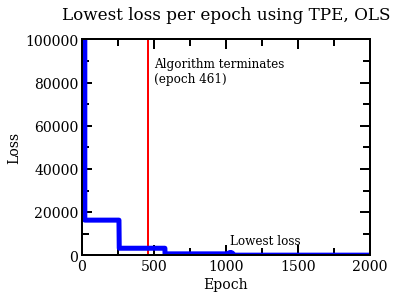

In [247]:
lowest_loss_epoch = np.argmin(best_per_epoch_ols_orig)
lowest_loss = np.min(best_per_epoch_ols_orig)

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])

# Evaluation
plt.plot(best_per_epoch_ols_orig, linewidth=5, color='#0000FF')
plt.vlines(461, ymin=0, ymax=100_000, colors=['red'], linewidth=2)
plt.plot(lowest_loss_epoch, lowest_loss,'ro', color='#0000FF', markersize=10) 
plt.xlim(0,2000)
plt.ylim(0,100_000)
plt.title("Lowest loss per epoch using TPE, OLS", pad=20)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.text(500, 80000, "Algorithm terminates\n(epoch 461)", fontsize=12)
plt.text(lowest_loss_epoch, 5000, "Lowest loss", horizontalalignment="left", fontsize=12)

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(500))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(250))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(20_000))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10_000))

plt.show()

## b. Strong Neural Net (with MNIST) <a class="anchor" id="2b"></a>

In [ ]:
def early_stop_objective_err(params):
    params['batch_size'] = int(2**params['batch_size'])
    
    global stopped
    global losses

    if stopped:
        return losses[-1]
    else:
        global max_epochs
        global min_loss
        global min_loss_idx
        
        val_errs = run_model(batch_size=params['batch_size'], 
                            alpha=params['alpha'],
                            beta=params['beta'],
                            model_to_use=params['model_to_use'])
        
        loss = val_errs[-1]  

        if loss < min_loss or len(losses) == 0:
            min_loss = loss
            min_loss_idx = len(losses)+1

        losses.append(loss)

        if len(losses) > max_epochs // 5 and min_loss_idx < len(losses) - max_epochs//10:
            # we're past 20% mark, and new min hasn't been found in the last 10% of epochs
            stopped = True
            print(f"Stopped at iteration {len(losses)}")
        return loss

In [ ]:
space = {
    'batch_size': hp.quniform('batch_size', 4, 7, 1),
    'alpha': hp.uniform('alpha', 0.00001, 0.1),
    'beta': hp.uniform('beta', 0, 1),
    'model_to_use': hp.choice('model_to_use', ["simple", "larger"])
}

In [ ]:
losses = []
stopped = False
max_epochs = 100
min_loss = -1
min_loss_idx = -1

tpe_algo = tpe.suggest
tpe_trials = Trials()

tpe_best = fmin(fn=early_stop_objective_err, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=max_epochs, rstate= np.random.RandomState(50))

print(f"Optimal parameters are: {tpe_best}")

Stopped at iteration 32
100%|██████████| 100/100 [24:14<00:00, 14.54s/it, best loss: 0.023]
Optimal parameters are: {'alpha': 0.09750362254227268, 'batch_size': 4.0, 'beta': 0.5017266693719692, 'model_to_use': 1}


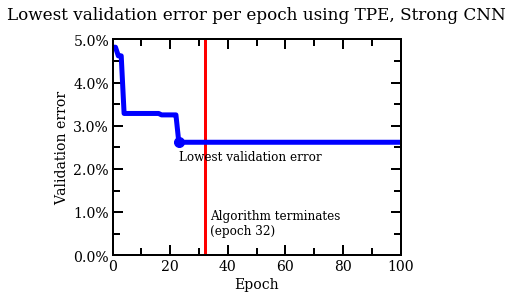

In [244]:
# Evaluation
best_per_epoch_mnist = [0.04816666666666667, 0.04816666666666667, 0.04616666666666667, 0.04616666666666667, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.03283333333333333, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.0325, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668, 0.026166666666666668]

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(best_per_epoch_mnist, linewidth=5, color='#0000FF')
plt.vlines(32, ymin=0, ymax=0.05, colors=['red'], linewidth=3)
plt.plot(23, 0.026166666666666668,'ro', color='#0000FF', markersize=10) 
plt.xlim(0,100)
plt.ylim(0, 0.05)
plt.title("Lowest validation error per epoch using TPE, Strong CNN", pad=20)
plt.xlabel("Epoch")
plt.ylabel("Validation error")
plt.text(34, 0.005, "Algorithm terminates\n(epoch 32)", fontsize=12)
plt.text(23, 0.022, "Lowest validation error", fontsize=12)

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.01))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: str(round(100*float(x), 1)) + "%"))

plt.show()

## c. Weak Neural Net (with CIFAR-10) <a class="anchor" id="2c"></a>

In [ ]:
cifar_space = {
    'batch_size': hp.quniform('batch_size', 4, 7, 1),
    'alpha': hp.uniform('alpha', 0.00001, 0.1),
    'beta': hp.uniform('beta', 0, 1)
}

In [ ]:
def early_stop_cifar_objective_err(params):
    params['batch_size'] = int(2**params['batch_size'])
    
    global cifar_stopped
    global cifar_losses

    if cifar_stopped:
        return cifar_losses[-1]
    else:
        global cifar_max_epochs
        global cifar_min_loss
        global cifar_min_loss_idx
        
        val_errs = run_cifar_model(batch_size=params['batch_size'], 
                            alpha=params['alpha'],
                            beta=params['beta'])
        
        loss = val_errs[-1]  

        if loss < cifar_min_loss or len(cifar_losses) == 0:
            cifar_min_loss = loss
            cifar_min_loss_idx = len(cifar_losses)+1

        cifar_losses.append(loss)

        if len(cifar_losses) > cifar_max_epochs // 5 and cifar_min_loss_idx < len(cifar_losses) - cifar_max_epochs//10:
            # we're past 20% mark, and new min hasn't been found in the last 10% of epochs
            cifar_stopped = True
            print(f"Stopped at iteration {len(cifar_losses)}")
        return loss

In [ ]:
cifar_losses = []
cifar_stopped = False
cifar_max_epochs = 100
cifar_min_loss = -1
cifar_min_loss_idx = -1

cifar_tpe_algo = tpe.suggest
cifar_tpe_trials = Trials()

cifar_tpe_best = fmin(fn=early_stop_cifar_objective_err, space=cifar_space, algo=cifar_tpe_algo, trials=cifar_tpe_trials, 
                max_evals=cifar_max_epochs, rstate= np.random.RandomState(50))

print(f"Optimal parameters are: {cifar_tpe_best}")

Stopped at iteration 23
100%|██████████| 100/100 [05:09<00:00,  3.09s/it, best loss: 0.5578333333333333]
Optimal parameters are: {'alpha': 0.02879559665928576, 'batch_size': 4.0, 'beta': 0.8071413385798568}


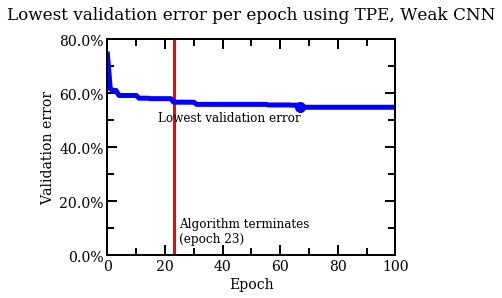

In [245]:
# Evaluation
error_per_epoch_cifar = [0.7451666666666666,0.6166666666666667,0.6105,0.7451666666666666,0.592,0.5928333333333333,0.5946666666666667,0.7528333333333334,0.6708333333333333,0.6048333333333333,0.7138333333333333,0.5818333333333333,0.6235,0.6676666666666666,0.6103333333333333,0.5801666666666667,0.6226666666666667,0.6551666666666667,0.7451666666666666,0.686,0.6743333333333333,0.7451666666666666,0.7451666666666666,0.5671666666666667,0.569,0.5961666666666666,0.604,0.567,0.6453333333333333,0.5893333333333334,0.6373333333333333,0.559,0.6353333333333333,0.5611666666666667,0.5948333333333333,0.5721666666666667,0.572,0.5753333333333334,0.6703333333333333,0.5805,0.618,0.566,0.668,0.6536666666666666,0.5818333333333333,0.61,0.6138333333333333,0.69,0.5975,0.5808333333333333,0.6023333333333334,0.6508333333333334,0.7193333333333334,0.6068333333333333,0.5828333333333333,0.6881666666666667,0.5568333333333333,0.6078333333333333,0.606,0.6861666666666667,0.5773333333333334,0.5651666666666667,0.5868333333333333,0.5815,0.556,0.5731666666666667,0.7451666666666666,0.5483333333333333,0.6078333333333333,0.575,0.569,0.5781666666666667,0.5768333333333333,0.6153333333333333,0.5576666666666666,0.6106666666666667,0.6298333333333334,0.5543333333333333,0.5876666666666667,0.7156666666666667,0.5978333333333333,0.5611666666666667,0.6043333333333333,0.5836666666666667,0.597,0.5758333333333333,0.5648333333333333,0.6083333333333333,0.7451666666666666,0.59,0.6061666666666666,0.5983333333333334,0.6161666666666666,0.644,0.7143333333333334,0.5566666666666666,0.6026666666666667,0.563,0.5661666666666667,0.6171666666666666,0.5665,0.5766666666666667,0.6006666666666667]
best_per_epoch_cifar = [min(error_per_epoch_cifar[:(i+1)]) for i in range(len(error_per_epoch_cifar))]

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])

plt.plot(best_per_epoch_cifar, linewidth=5, color='#0000FF')
plt.vlines(23, ymin=0, ymax=0.8, colors=['red'], linewidth=3)
plt.plot(67, 0.5483333333333333,'ro', color='#0000FF', markersize=10) 
plt.xlim(0,100)
plt.ylim(0,0.8)
plt.title("Lowest validation error per epoch using TPE, Weak CNN", pad=20)
plt.xlabel("Epoch")
plt.ylabel("Validation error")
plt.text(25, 0.05, "Algorithm terminates\n(epoch 23)", fontsize=12)
plt.text(67, 0.4983333333333333, "Lowest validation error", horizontalalignment='right', fontsize=12)

ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: str(round(100*float(x), 1)) + "%"))

plt.show()